In [1]:
import torch

from glob import glob
from skimage import io
from tensorboardX import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

from src.batch_generator import BatchGenerator, WraptorDataLoader
from src.command import Command
from src.models import LocalTransferNet, GlobalTransferer, RefinementNet
from src.train_utils import draw_scalar_value, draw_images

In [2]:
logs_directory = "experiments/test_tensorboard/logs"
board_port = 9000
board_timeout=24*60*60

In [3]:
writer = SummaryWriter(logs_directory) 
board = Command('tensorboard --logdir=run1:{} --port {}'.format(logs_directory, board_port))
board.run()

In [4]:
dir_paths = [logs_directory]
for path in dir_paths:
    try:
        os.mkdir(path)
    except:
        pass

In [5]:
import numpy as np
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)[..., None]
    return np.repeat(gray, 3, 2)


In [6]:
train_bg = BatchGenerator(glob("datasets/DAVIS/JPEGImages/480p/*")[:1], resize_shape=(64, 64, 3))
train_loader = WraptorDataLoader(train_bg, batch_size=1)

100%|██████████| 1/1 [00:00<00:00, 221.58it/s]


In [7]:
local_transfer_net = LocalTransferNet().double()
global_transferer = GlobalTransferer()

In [8]:
refinement_net = RefinementNet().double()

In [11]:
loss_function = torch.nn.L1Loss() #torch.nn.MSELoss() or torch.nn.L1Loss()
optimizer = torch.optim.Adam(list(local_transfer_net.parameters()) + list(refinement_net.parameters()), lr=2e-3)

In [12]:
from color_utils import rgb2lab_torch, lab2rgb_torch

In [13]:
iteration_num = 5000
verbose_every_it = 1

In [14]:
#I1, Ik_1, Ik
train_losses = []
for it in tqdm(range(iteration_num)):
    batch = next(iter(train_loader))
    I1_lab = rgb2lab_torch(batch[0], use_gpu=False)
    Ik_lab = rgb2lab_torch(batch[2], use_gpu=False)

    G1_array = np.array([rgb2gray(img.numpy()) for img in batch[0]])
    Gk_1_array = np.array([rgb2gray(img.numpy()) for img in batch[1]])
    Gk_array = np.array([rgb2gray(img.numpy()) for img in batch[2]])

    G1_tensor = torch.tensor(G1_array.transpose(0, 3, 1, 2), dtype=torch.double, requires_grad=False)
    Gk_1_tensor = torch.tensor(Gk_1_array.transpose(0, 3, 1, 2), dtype=torch.double, requires_grad=False)
    Gk_tensor = torch.tensor(Gk_array.transpose(0, 3, 1, 2), dtype=torch.double, requires_grad=False)

    local_batch_output = local_transfer_net.forward(Gk_1_tensor, Gk_tensor, batch[1].permute(0, 3, 1, 2))
    local_batch_output_lab = rgb2lab_torch(local_batch_output.permute(0, 2, 3, 1), use_gpu=False).permute(0, 3, 1, 2)

    global_batch_output = global_transferer.forward(G1_array[0], Gk_array[0], batch[0][0])
    global_batch_output = torch.tensor(global_batch_output[None, ...].transpose(0, 3, 1, 2), dtype=torch.double, requires_grad=False)
    global_batch_output_lab = rgb2lab_torch(global_batch_output.permute(0, 2, 3, 1), use_gpu=False).permute(0, 3, 1, 2)


    stacked_input_refinement = torch.cat([Gk_tensor[0:1], local_batch_output_lab[0:1], global_batch_output_lab], dim=1)

    refinement_output_lab = refinement_net(stacked_input_refinement).permute(0, 2, 3, 1)

    loss = loss_function(refinement_output_lab[..., 1:], Ik_lab[:1][..., 1:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    


    gt_l = Ik_lab[0, ..., 0][..., None]

    predicted_ab = refinement_output_lab[0, ..., 1:]

    result_lab = torch.cat((gt_l, predicted_ab), dim=2).cpu()
    result_rgb = lab2rgb_torch(result_lab, use_gpu=False)
    
    if (it % verbose_every_it) == 0:
        draw_scalar_value(writer, "losses", "train loss", loss.detach().cpu().numpy(), it)
        draw_images(writer, [batch[2][0].numpy()], [result_rgb.cpu().detach().numpy()], it)

    #io.imshow(np.concatenate((batch[2][0], result_rgb.cpu().detach().numpy()), 1))
    #io.show()

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
  6%|▌         | 290/5000 [29:

KeyboardInterrupt: 

In [2]:
Ik_lab

NameError: name 'Ik_lab' is not defined

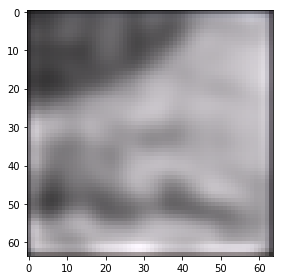

In [34]:
io.imshow(lab2rgb_torch(refinement_output_lab, use_gpu=False)[0].detach().numpy())

In [38]:
refinement_output_lab[0][..., 2].min()

tensor(-6.0350, dtype=torch.float64, grad_fn=<MinBackward1>)

In [29]:
lab2rgb_torch(Ik_lab, use_gpu=False)[0].numpy().shape

(64, 64, 3)

In [ ]:
class GlobalTransferer:
    def __init__(self, downscale_coef=4):
        self.downscale_coef = downscale_coef
        self.feature_extractor_net = ResNet101Extractor()
    
    def get_coarse_match(self, F_G1, F_Gk):
        closest = torch.zeros(F_G1.shape[0], F_G1.shape[1], 2)
        F_G1_tensor = torch.Tensor(F_G1.transpose(2, 0, 1))[None, ...]
        F_Gk_tensor = torch.Tensor(F_Gk)

        f2_g1 = torch.sum(F_G1_tensor ** 2, 1)[:, ...]
        f2_gk = torch.sum(F_Gk_tensor ** 2, -1)

        for i in range(F_Gk.shape[0]):
            fgk_row = F_Gk_tensor[i, :, :]
            fgk_row_g1 = F.conv2d(F_G1_tensor, fgk_row[:, :, None, None])[0]

            f2_gk_row = f2_gk[i, ...].reshape(-1, 1, 1)
            row_mse = ((f2_gk_row -2 * fgk_row_g1 + f2_g1).reshape(fgk_row_g1.shape[0], -1))

            mse_row_closest_indxs = torch.argmin(row_mse, -1)

            closest[i, :, 0] = mse_row_closest_indxs // F_G1.shape[1]
            closest[i, :, 1] = mse_row_closest_indxs % F_G1.shape[1]
        return closest.cpu().detach().numpy().astype(np.uint8)

In [327]:
import numpy as np

def get_coarse_match_old(F_G1, F_Gk):
    closest = torch.zeros(F_G1.shape[0], F_G1.shape[1], 2)
    F_G1_tensor = torch.Tensor(F_G1.transpose(2, 0, 1))[None, ...]
    F_Gk_tensor = torch.Tensor(F_Gk)

    f2_g1 = torch.sum(F_G1_tensor ** 2, 1)[:, ...]
    f2_gk = torch.sum(F_Gk_tensor ** 2, -1)

    for i in range(F_Gk.shape[0]):
        fgk_row = F_Gk_tensor[i, :, :]
        fgk_row_g1 = F.conv2d(F_G1_tensor, fgk_row[:, :, None, None])[0]

        f2_gk_row = f2_gk[i, ...].reshape(-1, 1, 1)
        row_mse = ((f2_gk_row -2 * fgk_row_g1 + f2_g1).reshape(fgk_row_g1.shape[0], -1))

        mse_row_closest_indxs = torch.argmin(row_mse, -1)

        closest[i, :, 0] = mse_row_closest_indxs // F_G1.shape[1]
        closest[i, :, 1] = mse_row_closest_indxs % F_G1.shape[1]
    return closest.cpu().detach().numpy().astype(np.uint8)

def get_coarse_match_new(F_G1, F_Gk):
    H, W, K = F_G1.shape[-3:]
    closest = torch.zeros(H, W, 2)
    F_G1_tensor = torch.Tensor(F_G1).cuda()
    F_Gk_tensor = torch.Tensor(F_Gk).cuda()
    
    weights = F_G1_tensor.reshape(H * W, K, 1, 1)
    input_tensor = F_Gk_tensor.permute(2, 0, 1).reshape(1, K, H, W)
    

    f2_g1 = torch.sum(F_G1_tensor ** 2, -1)[None, None, ...].reshape( H * W, 1, 1)
    f2_gk = torch.sum(F_Gk_tensor ** 2, -1)[None, None, ...]
    F_gk_g1 = F.conv2d(input_tensor, weights)[0]
    #print(f2_g1.shape)
    #print(F_gk_g1.shape)

    pathces_mse = (f2_gk + f2_g1 - 2 * F_gk_g1)[0]
    closes_patches_indxs = torch.argmin(pathces_mse, 0)
    closest[..., 0] = closes_patches_indxs // W
    closest[..., 1] = closes_patches_indxs % W
    
    return closest.cpu().detach().numpy().astype(np.uint8)
    

In [328]:
import torch.nn.functional as F
import torch

In [329]:
K = 1000
H = 100
W = 100
F_G1 = np.random.randn(H, W, K)
F_Gk = np.random.randn(H, W, K)

In [330]:
# F_G1 = np.arange(8).reshape(2, 2, 2)
# F_Gk = np.arange(8, 0, -1).reshape(2, 2, 2)

In [331]:
# F_Gk[1, 1]

In [332]:
# F_G1[1, 1]

In [333]:
%%time
res = get_coarse_match_new(F_G1, F_Gk)

AssertionError: Torch not compiled with CUDA enabled

In [326]:
%%time
res = get_coarse_match_old(F_G1, F_Gk)

CPU times: user 4.01 s, sys: 30.5 ms, total: 4.04 s
Wall time: 2.11 s


In [296]:
input_tensor.shape

torch.Size([1, 2, 3, 4])

In [20]:
weights.shape

torch.Size([12, 2, 1, 1])

In [22]:
F.conv2d(input_tensor, weights).shape

torch.Size([1, 12, 3, 4])